# Function

In [1]:
import os
from collections import Counter

def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)
        
# crop_img 저장
def save_crop_img(df,image,name):
    cnt = Counter(df['class'])[name]-1 # .jpg 파일 이름에 추가되는 변수
    # actor인 경우
    actor_path = f'./actor/{name}'
    createFolder(actor_path) # 폴더가 없다면 생성, 있다면 패스
    image.save(actor_path+f"/{name}_{cnt}.jpg") # actor폴더 하단에 저장

def changeFileName(src, pre_name, new_name):
    i=0
    for j in os.listdir(src+pre_name):
        os.rename(src+pre_name+'/'+j,src+pre_name+'/'+new_name+f'_{i}.jpg')
        i+=1

In [2]:
import math
from sklearn import neighbors
import os
import os.path
import pickle
from PIL import Image, ImageDraw
# import face_recognition
# from face_recognition.face_recognition_cli import image_files_in_folder
import matplotlib.pyplot as plt

from models import model_921
from detection import mtcnn_detect
from facenet_pytorch import MTCNN
import torch

ALLOWED_EXTENSIONS = {'png', 'jpg', 'jpeg'}
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mtcnn = MTCNN(
    image_size=224, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)
def train(model,mtcnn,train_dir, model_save_path=None, n_neighbors=None, knn_algo='ball_tree', verbose=False):
    '''
        model=model_921() or
        model = FaceNetModel().to(device)
        state = torch.load('./path/__.pth')
        model.load_state_dict(state['state_dict'])
    '''
    X = []
    y = []

    # Loop through each person in the training set
    train_dir = Path(train_dir)
    for class_dir in os.listdir(train_dir):
        if not os.path.isdir(train_dir/class_dir):
            continue

        # Loop through each training image for the current person
        for img_path in os.listdir(train_dir/class_dir):
            full_file_path = str(train_dir/class_dir/img_path)
            orig_image = Image.open(full_file_path)
            image = np.array(orig_image)
            face_bounding_boxes, boxes = mtcnn_detect(image,mtcnn,orig_box=True)
            
            
            if len(face_bounding_boxes) != 1:
                # If there are no people (or too many people) in a training image, skip the image.
                if verbose:
                    print("Image {} not suitable for training: {}".format(img_path, "Didn't find a face" if len(face_bounding_boxes) < 1 else "Found more than one face"))
            else:
                # Add face encoding for current image to the training set
                # X.append(face_recognition.face_encodings(image, known_face_locations=face_bounding_boxes)[0])
                faces = mtcnn.extract(image, boxes, save_path=None)
                x_aligned=[]
                x_aligned.append(faces)
                aligned = torch.stack(x_aligned).to(device)
                embeddings = model(aligned).detach().cpu()
                
                encoding_new = []
                for e in embeddings:
                    encoding_new.append(np.array(e))
                encoding_new = np.array(encoding_new).flatten()
                X.append(encoding_new)
                y.append(class_dir)

    # Determine how many neighbors to use for weighting in the KNN classifier
    if n_neighbors is None:
        n_neighbors = int(round(math.sqrt(len(X))))
        if verbose:
            print("Chose n_neighbors automatically:", n_neighbors)

    # Create and train the KNN classifier
    knn_clf = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm=knn_algo, weights='distance')
    knn_clf.fit(X, y)

    # Save the trained KNN classifier
    if model_save_path is not None:
        with open(model_save_path, 'wb') as f:
            pickle.dump(knn_clf, f)

    return knn_clf
def predict(X_img_path, knn_clf=None, model_path=None, distance_threshold=0.6):

    if not os.path.isfile(X_img_path) or os.path.splitext(X_img_path)[1][1:] not in ALLOWED_EXTENSIONS:
        raise Exception("Invalid image path: {}".format(X_img_path))

    if knn_clf is None and model_path is None:
        raise Exception("Must supply knn classifier either thourgh knn_clf or model_path")

    # Load a trained KNN model (if one was passed in)
    if knn_clf is None:
        with open(model_path, 'rb') as f:
            knn_clf = pickle.load(f)

    # Load image file and find face locations
    # X_img = face_recognition.load_image_file(X_img_path)
    # X_face_locations = face_recognition.face_locations(X_img)
    
    orig_image = Image.open(X_img_path)
    image = np.array(orig_image)
    X_face_locations, boxes = mtcnn_detect(image,mtcnn,orig_box=True)
    # resize_box = rescale(orig_image,224,X_face_locations,mtcnn=True)
    # If no faces are found in the image, return an empty result.
    if len(X_face_locations) == 0:
        return []

    # Find encodings for faces in the test iamge
    # faces_encodings = face_recognition.face_encodings(X_img, known_face_locations=X_face_locations)
    encoding_new = []
    are_matches = []
    # print(boxes)
    for box in boxes:
        box = np.array([box])
        # print(box)
        faces = mtcnn.extract(image, box, save_path=None)
    
        x_aligned=[]
        x_aligned.append(faces)
        aligned = torch.stack(x_aligned).to(device)
        embeddings = model(aligned).detach().cpu()
    
        for e in embeddings:
            encoding_new.append(np.array(e))
    # print("shape: ", np.array(encoding_new).shape)
    # print(encoding_new)
    # Use the KNN model to find the best matches for the test face
    closest_distances = knn_clf.kneighbors(encoding_new, n_neighbors=1)
    print(closest_distances)

    are_matches = [closest_distances[0][i][0] <= distance_threshold for i in range(len(X_face_locations))]
    # print(are_matches)
    # Predict classes and remove classifications that aren't within the threshold
    return [(pred, loc) if rec else ("unknown", loc) for pred, loc, rec in zip(knn_clf.predict(encoding_new), X_face_locations, are_matches)]


def show_prediction_labels_on_image(img_path, predictions):
    pil_image = Image.open(img_path).convert("RGB")
    draw = ImageDraw.Draw(pil_image)
    img = pil_image.copy()
    plt.figure(figsize=(20,5))
    i=0
    for name, (top, right, bottom, left) in predictions:
        # image crop
        plt.subplot(1, len(predictions), i+1)
        img_cropped = img.crop((left,top,right,bottom))
        plt.title(name)
        plt.imshow(img_cropped)
        i+=1
        # Draw a box around the face using the Pillow module
        draw.rectangle(((left, top), (right, bottom)), outline=(0, 0, 255))

        # There's a bug in Pillow where it blows up with non-UTF-8 text
        # when using the default bitmap font
        encoded_name = name.encode("UTF-8")
        
        # Draw a label with a name below the face
        text_width, text_height = draw.textsize(encoded_name)

        # 얼굴을 unknown으로 식별한 경우
        if name == 'unknown':
            draw.rectangle(((left, bottom - text_height - 10), (right, bottom)), fill="red", outline="red")
            draw.text((left + 6, bottom - text_height - 5), encoded_name, fill=(255, 255, 255, 255))
        # 특정 인물로 식별한 경우(이름 라벨을 가진 경우)
        else :
            draw.rectangle(((left, bottom - text_height - 10), (right, bottom)), fill=(0, 0, 255), outline=(0, 0, 255))
            draw.text((left + 6, bottom - text_height - 5), encoded_name, fill=(255, 255, 255, 255))

    # Remove the drawing library from memory as per the Pillow docs
    del draw

    # Display the resulting image
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1,1,1)
    ax.set_title('result')
    ax.imshow(pil_image)

#  Main

In [3]:
import pandas as pd
from models import FaceNetModel

ini_df = pd.DataFrame({'photo_ID':[], 'x_left':[], 'y_left':[],'x_right':[],'y_right':[],'class':[] })
ini_df.to_csv("photo_info.csv", index =False)
df = pd.read_csv('./photo_info.csv')

# model = model_921()
model = FaceNetModel().to(device)
state = torch.load('./last_checkpoint.pth')
model.load_state_dict(state["state_dict"])

input_dir = "./korean/"
name_dic = {}  # extra 이름(unknown_{})과 개수

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


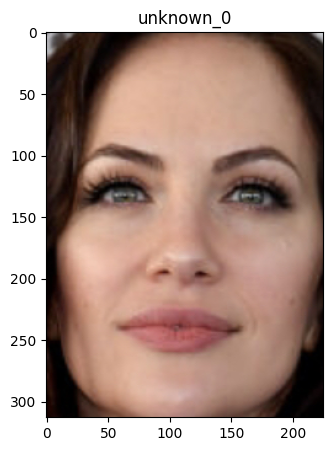

Training KNN classifier...
Training complete!
Looking for faces in maxresdefault.jpg
(array([[0.29781663],
       [0.56703789]]), array([[0],
       [0]]))
- Found unknown_0
- Found unknown_0
Training KNN classifier...
Training complete!
Looking for faces in 20211223135403415frrt.jpg
(array([[0.1541825 ],
       [0.22958148],
       [0.1917645 ]]), array([[1],
       [1],
       [2]]))
- Found unknown_0
- Found unknown_0
- Found unknown_0
Training KNN classifier...
Training complete!
Looking for faces in kuk202209050256.638x.0.jpg
(array([[0.19932833],
       [0.21894681],
       [0.5226076 ]]), array([[2],
       [4],
       [4]]))
- Found unknown_0
- Found unknown_0
- Found unknown_0
Training KNN classifier...
Training complete!
Looking for faces in 110918506.2.jpg
(array([[0.25854153],
       [0.20151398],
       [0.18948272]]), array([[6],
       [0],
       [8]]))
- Found unknown_0
- Found unknown_0
- Found unknown_0
Training KNN classifier...
Training complete!
완료


In [4]:
from PIL import Image, ImageDraw
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import shutil
from pathlib import Path

verbose = False
# image -> 파일명

######################################## csv파일이 비어있는 경우 ##############################################
if len(df)==0:
    cycle=0
    for pic_name in os.listdir(input_dir):
        orig_image = Image.open(input_dir + pic_name)

        # 첫번째로 입력된 사진인 경우
        if cycle==0:
            image = np.array(orig_image)
            face_locations=mtcnn_detect(image,mtcnn)
            # face_locations, resize_img = rescale(orig_image,224,pred_box, mtcnn=True, resize_img=True)
            i=0
            plt.figure(figsize=(5,5))
            for face_location in face_locations:
                x_left, y_left, x_right, y_right = face_location
                no_name = "unknown_{}".format(i)
                
                # name_dic 업데이트
                name_dic[no_name]=1
                # df 업데이트
                df.loc[len(df)] = [pic_name,x_left, y_left, x_right, y_right,no_name]
                img_cropped = orig_image.crop((x_left, y_left, x_right, y_right))
                plt.title(no_name)
                plt.imshow(img_cropped)
                
                # 사진에서 얼굴이 없는 경우(또는 인식못한 경우)
                if len(face_locations) != 1:
                    if verbose:
                        print("Image {} not suitable for training: {}".format(pic_name, "Didn't find a face" if len(face_locations) < 1 else "Found more than one face"))
                plt.show()
                i+=1
                # 라벨 요청
                answer = input(f"Do you want to specify a label  for {no_name}?[y/n] : ")
                if answer == 'y':
                    name = input(f"Who is {no_name} : ")
                    df = df.replace(no_name,name)  # df 업데이트
                    del(name_dic[no_name])  # name_dic 업데이트
                else :
                    name = no_name
                save_crop_img(df,img_cropped,name)
            cycle+=1
            
            # Train the KNN classifier and save it to disk
            print("Training KNN classifier...")
            classifier = train(model, mtcnn,"actor", model_save_path="trained_knn_model_actor.clf", n_neighbors=2)
            print("Training complete!")

        # 첫번째 사진을 제외한 사진들에 대해서 진행
        else :
            print("Looking for faces in {}".format(pic_name))
            predictions = predict(input_dir + pic_name, model_path="trained_knn_model_actor.clf")

            # Print results on the console
            for name, (x_left, y_left, x_right, y_right) in predictions:
                print("- Found {}".format(name))
                img_cropped = orig_image.crop((x_left, y_left, x_right, y_right))
                
                # extra가 있는 경우
                if 'unknown' in name:
                    # 모르는 얼굴('unknown')이 있는 경우
                    if name == 'unknown':
                        # name_dic 업데이트
                        if name_dic :
                            last_name=list(name_dic.keys())[-1]
                            x=str(last_name).split('_')[-1]
                            name = f'unknown_{int(x)+1}'
                        else :
                            name = f'unknown_{len(name_dic)+1}'
                        name_dic[name]=1
                    # 아는 extra가 있는 경우
                    else :
                        name_dic[name]+=1
                # df 업데이트
                df.loc[len(df)] = [pic_name,x_left, y_left, x_right, y_right,name]
                save_crop_img(df,img_cropped,name)

                # # name_dic에 value가 3인 key가 있는지 체크
                # del_list=[]
                # for k, v in name_dic.items():
                #     # 라벨 요청
                #     if v==3:
                #         plt.imshow(img_cropped)
                #         plt.title(k)
                #         plt.show()
                #         print(f"There are 3 pictures of {k}")
                #         answer = input(f"Do you want to specify a label  for {k}?[y/n] : ")
                #         if answer == 'y':
                #             name = input(f"Who is {k} : ")
                #             changeFileName('./actor/',k,name) # 파일 이름 변경 (unknown_?_? -> name_?)
                #             os.rename('./actor/'+k,'./actor/'+name) # 폴더 이름 변경 (unknown_? -> name)
                #             shutil.rmtree('./extra/',k) # extra에 있는 폴더 삭제
                #             df = df.replace(k,name)  # df 업데이트
                #             del_list.append(k)
                # for n in del_list:
                #     del(name_dic[n])  # name_dic 업데이트
            
            print("Training KNN classifier...")
            classifier = train(model, mtcnn,"actor", model_save_path="trained_knn_model_actor.clf", n_neighbors=2)
            print("Training complete!")

######################################### csv파일이 비어있지 않은 경우 ##############################################
else :
    for pic_name in os.listdir(input_dir):
        if pic_name in df['photo_ID'].unique():
            continue
        orig_image = Image.open(input_dir + pic_name)
        print("Looking for faces in {}".format(pic_name))
        predictions = predict(input_dir + pic_name, model_path="trained_knn_model_actor.clf")

        # Print results on the console
        for name, (x_left, y_left, x_right, y_right) in predictions:
            print("- Found {}".format(name))
            img_cropped = orig_image.crop((x_left, y_left, x_right, y_right))
            
            # extra가 있는 경우
            if 'unknown' in name:
                # 모르는 얼굴('unknown')이 있는 경우
                if name == 'unknown':
                    # name_dic 업데이트
                    if name_dic :
                        last_name=list(name_dic.keys())[-1]
                        x=str(last_name).split('_')[-1]
                        name = f'unknown_{int(x)+1}'
                    else :
                        name = f'unknown_{len(name_dic)+1}'
                    name_dic[name]=1
                # 아는 extra가 있는 경우
                else :
                    name_dic[name]+=1
            # df 업데이트
            df.loc[len(df)] = [pic_name,x_left, y_left, x_right, y_right,name]
            save_crop_img(df,img_cropped,name)

            # name_dic에 value가 3인게 있는지 체크
            del_list=[]
            for k, v in name_dic.items():
                # 라벨 요청
                if v==3:
                    plt.imshow(img_cropped)
                    plt.title(k)
                    plt.show()
                    print(f"There are 3 pictures of {k}")
                    answer = input(f"Do you want to specify a label  for {k}?[y/n] : ")
                    if answer == 'y':
                        name = input(f"Who is {k} : ")
                        changeFileName('./actor/',k,name) # 파일 이름 변경 (unknown_?_? -> name_?)
                        os.rename('./actor/'+k,'./actor/'+name) # 폴더 이름 변경 (unknown_? -> name)
                        df = df.replace(k,name)  # df 업데이트
                        del_list.append(k)

            for n in del_list:
                del(name_dic[n])  # name_dic 업데이트

        print("Training KNN classifier...")
        classifier = train(model,mtcnn,"actor", model_save_path="trained_knn_model_actor.clf", n_neighbors=2)
        print("Training complete!")
print('완료')

In [5]:
df

,photo_ID,x_left,y_left,x_right,y_right,class
0,kate_siegel.jpg,537.601501,100.744949,762.716736,414.091370,unknown_0
1,maxresdefault.jpg,735.148926,85.587959,1067.604614,537.940979,unknown_0
2,maxresdefault.jpg,190.533417,137.091492,512.493591,541.742859,unknown_0
3,20211223135403415frrt.jpg,395.870758,41.745636,566.813782,256.779144,unknown_0
4,20211223135403415frrt.jpg,26.257895,16.212095,164.954941,215.870682,unknown_0
5,20211223135403415frrt.jpg,212.930893,33.561100,351.338562,228.509445,unknown_0
6,kuk202209050256.638x.0.jpg,144.844009,18.180534,283.056488,213.935211,unknown_0
7,kuk202209050256.638x.0.jpg,272.355103,301.104218,406.232971,470.634064,unknown_0
8,kuk202209050256.638x.0.jpg,340.260803,558.957947,466.381653,727.881897,unknown_0
9,110918506.2.jpg,53.513187,48.346321,151.004211,196.299210,unknown_0


In [12]:
df

,photo_ID,x_left,y_left,x_right,y_right,class
0,maxresdefault.jpg,735.148926,85.587975,1067.604614,537.940979,goeun
1,maxresdefault.jpg,190.533417,137.091537,512.493530,541.742859,jihyun
2,kuk202209050256.638x.0.jpg,144.844009,18.180523,283.056488,213.935211,jihyun
3,kuk202209050256.638x.0.jpg,272.355103,301.104248,406.232971,470.634125,jihyun
4,kuk202209050256.638x.0.jpg,340.260773,558.957825,466.381622,727.881775,unknown_1


In [8]:
name_dic

{}

In [32]:
train_dir ='actor'
from pathlib import Path
train_dir = Path(train_dir)
for class_dir in os.listdir(train_dir):
    if os.path.isdir(train_dir/class_dir):
        print('yes')
    for img_path in os.listdir(train_dir/class_dir):
        full_file_path = str(train_dir / class_dir / img_path)
        break

yes
yes
yes
